# Notebook for the decision tree task

In [3]:
# imports

import matplotlib.pyplot as plt
import numpy as np

# Import Pandas and NumPy functionality for editing data
import pandas as pd
import seaborn as sns

# Importing IPython display for visualizing intermediate results in the notebook
from IPython.display import display

# decision tree
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

Load the train and test data sets

In [4]:
train_dataset_oh = pd.read_csv('./train_insurance_one_hot.csv')
x_train = train_dataset_oh.drop(columns=['id','charges','chargeGroup'], inplace=False)
y_train = train_dataset_oh[["chargeGroup"]]

test_dataset_oh = pd.read_csv('./test_insurance_one_hot.csv')
x_test = test_dataset_oh.drop(columns=['id','charges','chargeGroup'], inplace=False)
y_test = test_dataset_oh[["chargeGroup"]]

## a)

In [5]:
# Wishful-thinking model: always predict 'low'
wishful_predictions = pd.Series(['low'] * len(y_test), index=y_test.index, name='chargeGroup')
wishful_accuracy = (wishful_predictions.values == y_test['chargeGroup'].values).mean()
print(f"Wishful-thinking model accuracy on the test set: {wishful_accuracy:.2%}")
wishful_accuracy


Wishful-thinking model accuracy on the test set: 48.88%


0.48880597014925375

Wishful-thinking model accuracy on the test set: **48.88%**.

## b)

In [6]:
# Mode-based model: always predict the training-set mode
charge_group_mode = y_train['chargeGroup'].mode().iloc[0]
print(f"Mode of chargeGroup in train set: {charge_group_mode}")
mode_predictions = pd.Series([charge_group_mode] * len(y_test), index=y_test.index, name='chargeGroup')
mode_accuracy = (mode_predictions.values == y_test['chargeGroup'].values).mean()
print(f"Mode-based model accuracy on the test set: {mode_accuracy:.2%}")
accuracy_vs_wishful = mode_accuracy - wishful_accuracy
print(f"Accuracy difference vs. wishful-thinking model: {accuracy_vs_wishful:+.2%}")
mode_accuracy


Mode of chargeGroup in train set: medium
Mode-based model accuracy on the test set: 38.81%
Accuracy difference vs. wishful-thinking model: -10.07%


0.3880597014925373

Mode of the training `chargeGroup`: **medium**.
Mode-based test accuracy: **38.81%** (`0.3881`).
This is lower than the wishful-thinking baseline (48.88%) because the test set contains more "low" cases than "medium", so copying the training mode does not align with the test distribution, whereas always predicting "low" does.

## c)

Best max_depth: 4 | Accuracy: 94.03%


,max_depth,accuracy
0,1,0.746269
1,2,0.847015
2,3,0.917910
3,4,0.940299
4,5,0.940299
5,6,0.940299
6,7,0.940299
7,8,0.940299
8,9,0.940299


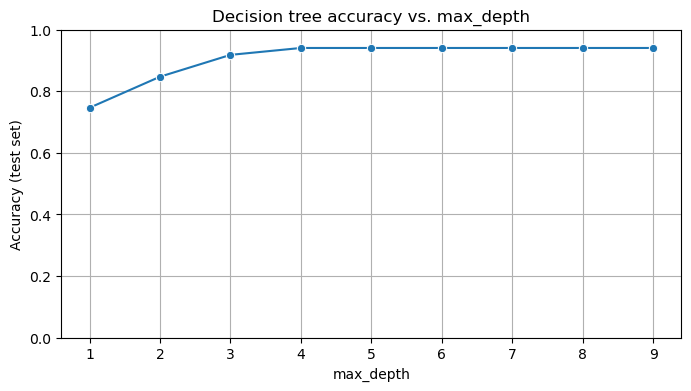

(4, 0.9402985074626866)

In [7]:
# Decision tree depth sweep using entropy criterion
max_depth_values = list(range(1, 10))
dt_results = []
# Train and evaluate one model per depth setting
for depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=6,
        random_state=42,
        max_depth=depth,
    )
    clf.fit(x_train, y_train['chargeGroup'])
    accuracy = clf.score(x_test, y_test['chargeGroup'])
    dt_results.append({'max_depth': depth, 'accuracy': accuracy})

# Turn the list into a DataFrame so it’s easy to inspect and plot
dt_results_df = pd.DataFrame(dt_results)
best_row = dt_results_df.loc[dt_results_df['accuracy'].idxmax()]
best_depth = int(best_row['max_depth'])
best_accuracy = float(best_row['accuracy'])
print(f"Best max_depth: {best_depth} | Accuracy: {best_accuracy:.2%}")
display(dt_results_df)

# Plot accuracy vs. max_depth
plt.figure(figsize=(8, 4))
sns.lineplot(data=dt_results_df, x='max_depth', y='accuracy', marker='o')
plt.title('Decision tree accuracy vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy (test set)')
plt.xticks(max_depth_values)
plt.ylim(0, 1)
plt.grid()
plt.show()

best_depth, best_accuracy


Best-performing max_depth: **4** (first depth reaching the top accuracy).  
Highest test accuracy achieved: **94.03%**.  
I would pick `max_depth = 4` because deeper trees do not improve accuracy yet increase complexity, so the shallower tree is less likely to overfit.

## d)

In [8]:
x_train.describe()
y_train.describe()

,chargeGroup
count,1070
unique,3
top,medium
freq,509


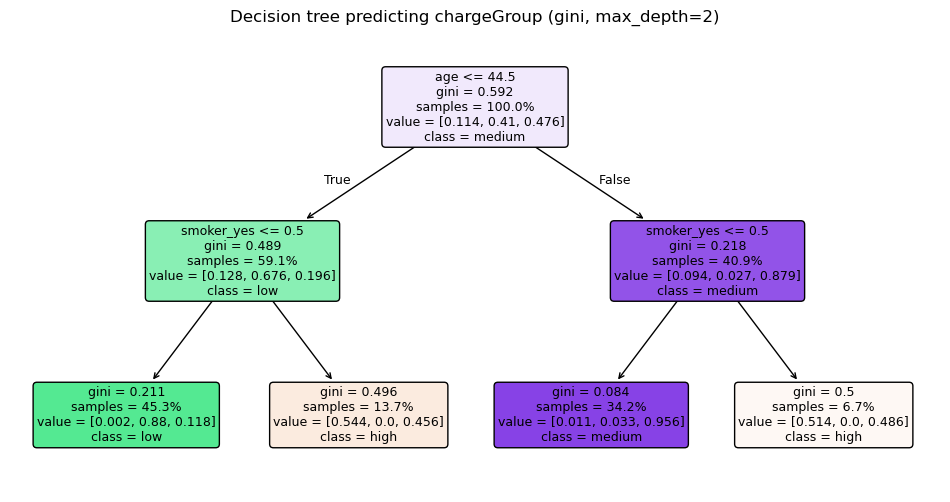

|--- age <= 44.50
|   |--- smoker_yes <= 0.50
|   |   |--- class: low
|   |--- smoker_yes >  0.50
|   |   |--- class: high
|--- age >  44.50
|   |--- smoker_yes <= 0.50
|   |   |--- class: medium
|   |--- smoker_yes >  0.50
|   |   |--- class: high

Rules leading to 'medium':
1. age > 44.50 and smoker_yes <= 0.50
Predicted chargeGroup for the 42-year-old non smoking male: low


'low'

In [ ]:
# Train a shallow decision tree using Gini impurity
gini_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    min_samples_leaf=6,
    random_state=42,
    max_depth=2,
)
gini_tree.fit(x_train, y_train['chargeGroup'])

# Visualize the tree structure
plt.figure(figsize=(12, 6))
plot_tree(
    gini_tree,
    feature_names=x_train.columns,
    class_names=gini_tree.classes_,
    filled=True,
    rounded=True,
    impurity=True,
    proportion=True,
    fontsize=9,
)
plt.title('Decision tree predicting chargeGroup (gini, max_depth=2)')
plt.show()

# Print a text summary of the splits
from sklearn.tree import export_text
print(export_text(gini_tree, feature_names=list(x_train.columns)))

medium_rules = []
tree_struct = gini_tree.tree_
feature_names = x_train.columns

def collect_rules(node=0, conditions=None):
    # Recursively walk the tree and collect rules that predict "medium"
    if conditions is None:
        conditions = []
    feature_index = tree_struct.feature[node]
    if feature_index != -2:  # Not a leaf: branch on threshold
        threshold = tree_struct.threshold[node]
        feature_name = feature_names[feature_index]
        collect_rules(
            tree_struct.children_left[node],
            conditions + [f"{feature_name} <= {threshold:.2f}"],
        )
        collect_rules(
            tree_struct.children_right[node],
            conditions + [f"{feature_name} > {threshold:.2f}"],
        )
    else:  # Leaf node: check predicted class
        prediction = gini_tree.classes_[tree_struct.value[node][0].argmax()]
        if prediction == 'medium':
            medium_rules.append(" and ".join(conditions) if conditions else 'All records')

collect_rules()
print("Rules leading to 'medium':")
for idx, rule in enumerate(medium_rules, 1):
    print(f"{idx}. {rule}")

# Example prediction for a sample person from the task description
sample_features = pd.DataFrame(
    [{
        'age': 42,
        'bmi': 36,
        'children': 2,
        'sex_female': 0,
        'sex_male': 1,
        'smoker_no': 1,
        'smoker_yes': 0,
        'region_northeast': 0,
        'region_northwest': 1,
        'region_southeast': 0,
        'region_southwest': 0,
    }],
    columns=x_train.columns,
)
sample_prediction = gini_tree.predict(sample_features)[0]
print(f"Predicted chargeGroup for the 42-year-old non smoking male: {sample_prediction}")
sample_prediction



* The tree classifies `chargeGroup` as **medium** only when `age > 44.5` and `smoker_yes <= 0.5` (i.e., a non-smoker over ~45).
* All other branches (younger people or smokers) predict `low` or `high`, so being older and smoke-free is the distinguishing pattern for the medium leaf.
* The specified 42-year-old non-smoking male from the northwest is predicted as **low** because he falls into the `age <= 44.5` branch, which routes to the low leaf.
